In [1]:
#import image from the computer
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import imageio
from findpeaks import findpeaks
import scipy as sp

volume_properties= []

In [2]:
# current functions

def count_pixels(saved_masked_img):
    pixel_total_masked = 0
    for i in range(0, saved_masked_img.shape[0]):
        for j in range(0, saved_masked_img.shape[1]):
            if saved_masked_img[i][j][0] != 0:
                pixel_total_masked += 1
    return pixel_total_masked


def thresholding(threshold, historgram):
    pulse_start_end= []
    hist_pulse_area= []
    hist_tr= historgram > threshold
    hist_tr = hist_tr.astype(int)

    hist_total_pulse_area= np.sum(hist_tr)
   # add tolerance to the thresholding
    max_tol= 3
    tol1=0
    tol2=0
    for i in range(1, len(hist_tr)):
        if hist_tr[i] == 1 and hist_tr[i-1] == 0:
            tol1=tol1 + 1
            if tol1==max_tol:
                pulse_start_end.append(i)
                tol1=0
        if hist_tr[i] == 0 and hist_tr[i-1] == 1:
            tol2=tol2 + 1
            if tol2==max_tol:
                pulse_start_end.append(i)
                tol2=0

    for i in range(0, len(pulse_start_end)//2 ):
        hist_pulse_area.append(np.sum(hist_tr[pulse_start_end[2*i]:pulse_start_end[2*i+1]]))
        hist_tr[pulse_start_end[2*i]:pulse_start_end[2*i +1]] = hist_pulse_area[i]
    return hist_tr, hist_pulse_area, pulse_start_end

def make_new_image(rgb_img, mask):
    red = rgb_img[:,:,0]*mask
    green = rgb_img[:,:,1]*mask
    blue = rgb_img[:,:,2]*mask
    masked_img = np.dstack((red,green,blue))
    return masked_img
    


In [3]:
def make_material_image(masked_img,hue, saturation,value, material_colors_img, material_shading_img):

    # make a new image with the material color
    # for each pixel in the masked image that is not zero, set the hue, saturation, and value
    # of the pixel in the material color image to the hue, saturation, and value of the pixel

    for i in range(0, masked_img.shape[0]):
        for j in range(0, masked_img.shape[1]):
            if masked_img[i][j][0] != 0: # if the pixel is not black
                material_colors_img[i][j][0] = hue
                material_colors_img[i][j][1] = saturation
                material_colors_img[i][j][2] = value

                # make a new image with the material shading
                material_shading_img[i][j][0] = 125
                material_shading_img[i][j][1] = 0.5*(masked_img[i][j][1] - saturation) + 125
                material_shading_img[i][j][2] = 0.5*(masked_img[i][j][2] - value) + 125

    return material_colors_img, material_shading_img

In [24]:
def extract_color(hue_material_number,masked_img, material_colors_img, material_shading_img , hue, show_graphs=False):
                                                                             
                                                                             
    masked_hsv_img = cv.cvtColor(masked_img, cv.COLOR_RGB2HSV)
    total_pixels_masked= count_pixels(masked_hsv_img)
    if total_pixels_masked <= 15:
        if show_graphs:
            print('invalid material')
        hue_material_number ='N'
        return
    
    threshold= 70 # for saturation

    s = masked_hsv_img[:,:,1]
    v = masked_hsv_img[:,:,2]

    hist_s = cv.calcHist([s],[0],None,[256],[0,255])
    hist_s_lesstimebins= cv.calcHist([s],[0],None,[25],[0,255])
    hist_v = cv.calcHist([v],[0],None,[256],[1,255]) # excluding black background
    
    peaks_s,fp_scipy_s = sp.signal.find_peaks(hist_s.transpose()[0], prominence = total_pixels_masked*0.01, distance = 5, wlen=40)
    if (len(fp_scipy_s['prominences'])!=0):
        s_hist_tr, s_hist_pulse_area, s_pulse_start_end= thresholding(threshold, hist_s)
        #print( s_pulse_start_end, ' s_pulse_start_end')
        s_threshold = np.divide( s_hist_tr, total_pixels_masked)
        if len(s_pulse_start_end)== 0:
            if show_graphs:
                print('there are no distinct peaks in saturation, here is the saturation histogram')
                # show saturation histogram
                plt.figure()
                plt.plot(hist_s_lesstimebins, color='g', label="saturation with less timebins")
                plt.title('saturation with less timebins')

            saturation= peaks_s[-1]
            
        
        else:
            if len(s_pulse_start_end)<= 2:
                if show_graphs:
                    print('there is only one distinct peak in saturation')
                saturation= s_pulse_start_end[0]
            else:
                if show_graphs:
                     print('there are several distinct peaks in saturation')
                hue_material_number ='N'
                # calculate new mask ans apply
                for i in range(0, len(s_pulse_start_end)//2):
                    lower_mask = masked_hsv_img[:,:,1] >= s_pulse_start_end[2*i]
                    upper_mask = masked_hsv_img[:,:,1] <= s_pulse_start_end[2*i + 1]
                    mask = upper_mask*lower_mask
                    new_image= make_new_image(masked_img, mask) # for making a rgb image 
                    extract_color(0, new_image, material_colors_img, material_shading_img ,hue,0)


    else:
        if show_graphs: 
             print('invalid material Saturation')
        hue_material_number ='N'
    
    
    peaks_v,fp_scipy_v = sp.signal.find_peaks(hist_v.transpose()[0], prominence = total_pixels_masked*0.005, distance = 5, wlen=40)
    if (len(fp_scipy_v['prominences'])!=0):
        v_hist_tr, v_hist_pulse_area, v_pulse_start_end= thresholding(threshold, hist_v)
        v_hist_tr = np.divide( v_hist_tr, total_pixels_masked)
        value= peaks_v[-1]

    else:
        if show_graphs:
            print('invalid material Value')
        hue_material_number= 'N'
    

    if(show_graphs and hue_material_number !='N'):
        print('there are distinct peaks in saturation and value, here are the saturation and value histograms')
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.plot(hist_s[1:], color='g', label="saturation")
        plt.plot(hist_s[1:], color='g', label="saturation less time bins")
        plt.scatter(peaks_s, hist_s[peaks_s], color='r')
        plt.title(' Sat')

        plt.subplot(1, 2, 2)
        plt.plot(hist_v, color='b', label="value")
        plt.scatter(peaks_v, hist_v[peaks_v], color='g')
        plt.title(' Value ')
        plt.show()

        # show the color with different V and S
        color_prominence= np.ones((250,250,3))

        color_prominence[:,:,0]= hue
        for i in range(0,250):
            color_prominence[:,i,1]= color_prominence[:,i,1]* i #S
            color_prominence[i,:,2]= color_prominence[i,:,2]* (250-i) # V

        color_prominence = cv.convertScaleAbs(color_prominence)
        color_prominence_RGB = cv.cvtColor(color_prominence, cv.COLOR_HSV2RGB)
        plt.figure()
        plt.imshow(color_prominence_RGB)
        plt.xlabel('Increasing Saturation --> ')
        plt.ylabel('Increasing Value -->')
        plt.title('The extracted color of the object')
        
    if hue_material_number !='N':

        final_color=np.ones((50,50,3))
        final_color[:,:,0]=  hue
        final_color[:,:,1]=  saturation
        final_color[:,:,2]=  value 
        final_color = cv.convertScaleAbs(final_color)
        final_color_RGB = cv.cvtColor(final_color, cv.COLOR_HSV2RGB)
    
        if show_graphs:
            print('final color of object')
            plt.figure()
            plt.subplot(1, 2, 1) # row 1, col 2 index 1
            plt.imshow(masked_img)
        
            plt.subplot(1, 2, 2) # index 2
            plt.imshow(final_color_RGB)
            plt.title('Final color of object')

        material_colors_img, material_shading_img = make_material_image(masked_img, hue, saturation,value, material_colors_img, material_shading_img)

        if show_graphs:
            print('number of pixels of object above', total_pixels_masked,', HSV', hue, saturation,value)
    
        material_color_hsv= np.uint8([[[hue,saturation,value]]])  
        material_color_rgb = cv.cvtColor(material_color_hsv, cv.COLOR_HSV2RGB)
        # mat_number, where it acts, rgb alpha, enabled?
        volume_properties.append([total_pixels_masked,0,material_color_rgb[0][0][0], material_color_rgb[0][0][1], material_color_rgb[0][0][2], 255, 1])




In [9]:
def hsv_analysis(rgb_img,show_graphs= False):
    material_colors_img, material_shading_img= np.zeros((rgb_img.shape[0],rgb_img.shape[1],3)), np.zeros((rgb_img.shape[0],rgb_img.shape[1],3))
    hsv_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)

    pixel_total= hsv_img.shape[0]*hsv_img.shape[1]
    saved_masked_img= rgb_img

    h = hsv_img[:,:,0]
    hist_h = cv.calcHist([h],[0],None,[256],[0,256])
    total_pixels_img= count_pixels(hsv_img)

    peaks,fp_scipy = sp.signal.find_peaks(hist_h.transpose()[0], prominence = total_pixels_img*0.01, distance = 7, wlen=40)
    '''# sort peaks by prominence
    peaks= peaks[np.argsort(fp_scipy['prominences'])[::-1]]
    fp_scipy['prominences']= fp_scipy['prominences'][np.argsort(fp_scipy['prominences'])[::-1]]'''

    print('There are ',len(fp_scipy['prominences']),'Hue peaks')
    for hue_material_number in range(len(fp_scipy['prominences'])):

        #mask for object segmentation
        lower_mask = hsv_img[:,:,0] > fp_scipy['left_bases'][hue_material_number] 
        upper_mask = hsv_img[:,:,0] < fp_scipy['right_bases'][hue_material_number]
        mask = upper_mask*lower_mask

        #show segmented image
        red = rgb_img[:,:,0]*mask
        green = rgb_img[:,:,1]*mask
        blue = rgb_img[:,:,2]*mask
        masked_img = np.dstack((red,green,blue))
        extract_color(hue_material_number, masked_img, material_colors_img, material_shading_img , peaks[hue_material_number],show_graphs)
    return material_colors_img, material_shading_img

In [6]:
# vol properties by number of pixels 

def print_color(r,g,b):
    final_color=np.ones((30,30,3))
    final_color[:,:,0]=  r
    final_color[:,:,1]=  g
    final_color[:,:,2]=  b 
    #stack 
    final_color = cv.convertScaleAbs(final_color)
    return final_color
    
def show_vp(volume_properties, top=len(volume_properties), show=0):
    plt.figure()
    for i in range(0,top):
        #divide by 5 and round up
        plt.subplot(len(volume_properties)//5 +1, 5, i+1)
        color_image = print_color(volume_properties[i][2],volume_properties[i][3],volume_properties[i][4])
        plt.imshow(color_image)
        if show:
            plt.title(str(volume_properties[i][0])+ ',\n rgb: '+ str(volume_properties[i][2])+','+str(volume_properties[i][3])+','+str(volume_properties[i][4]))
        #dont show axis
        plt.xticks([])
        plt.yticks([])
        #make titles small
        plt.rcParams.update({'font.size': 6})
        #title to the right of image
        plt.subplots_adjust(right=0.8)
        #make break between images
        #plt.subplots_adjust(hspace=2.5)
        #plt.subplots_adjust(wspace=0.5)

There are  5 Hue peaks
there is only one distinct peak in saturation
there are distinct peaks in saturation and value, here are the saturation and value histograms


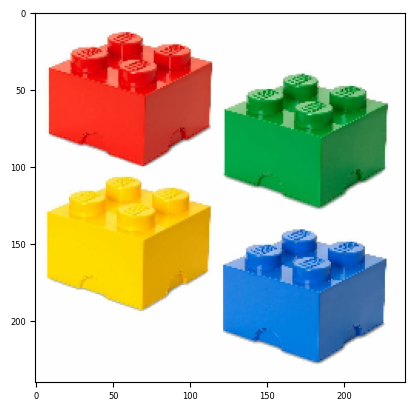

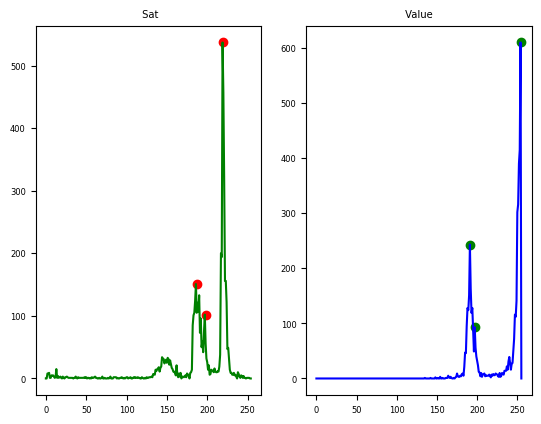

final color of object
number of pixels of object above 5112 , HSV 2 199 254
there is only one distinct peak in saturation
there are distinct peaks in saturation and value, here are the saturation and value histograms


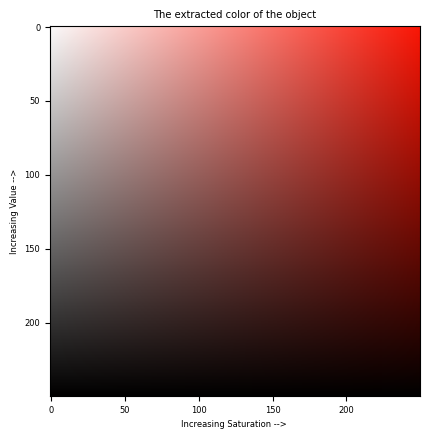

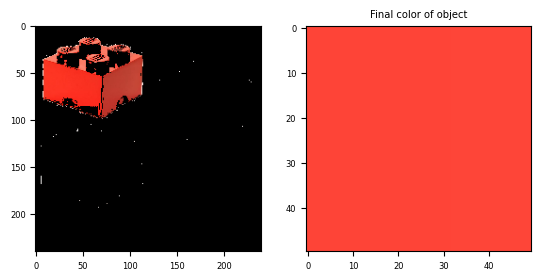

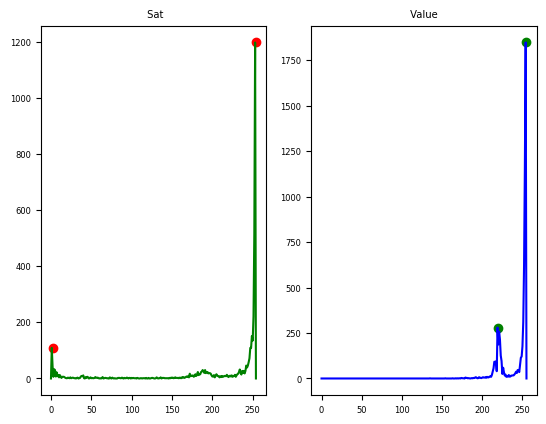

final color of object
number of pixels of object above 7302 , HSV 26 255 254
there are several distinct peaks in saturation
there are several distinct peaks in saturation
there are no distinct peaks in saturation, here is the saturation histogram
there are distinct peaks in saturation and value, here are the saturation and value histograms


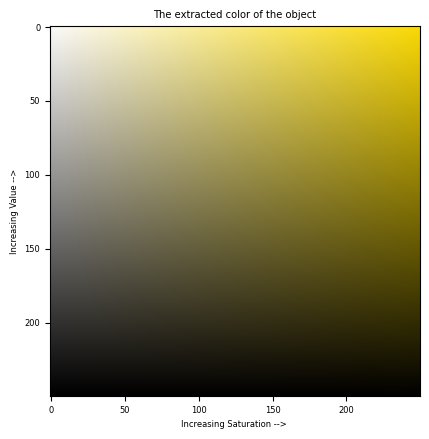

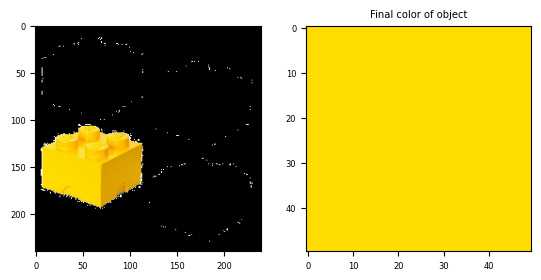

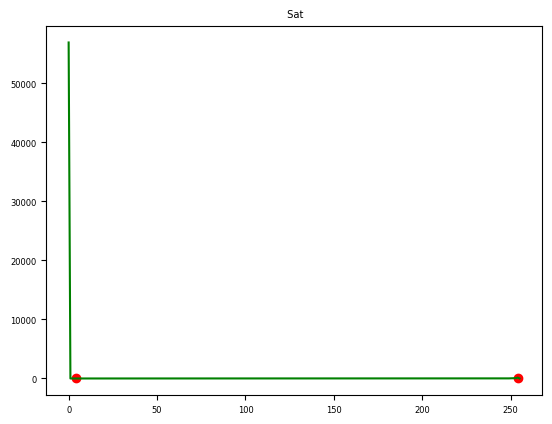

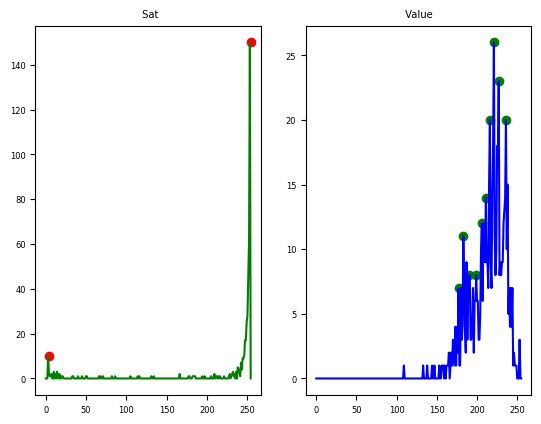

final color of object
number of pixels of object above 656 , HSV 179 254 236
there are  6  materials
volume properties [[7302, 0, 254, 220, 0, 255, 1], [5112, 0, 254, 69, 56, 255, 1], [656, 0, 236, 1, 9, 255, 1], [452, 0, 49, 161, 97, 255, 1], [201, 0, 9, 102, 225, 255, 1], [147, 0, 80, 141, 220, 255, 1]]


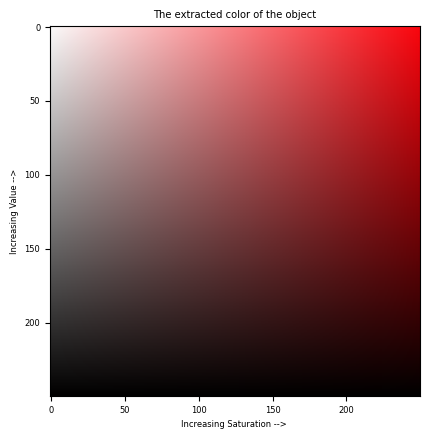

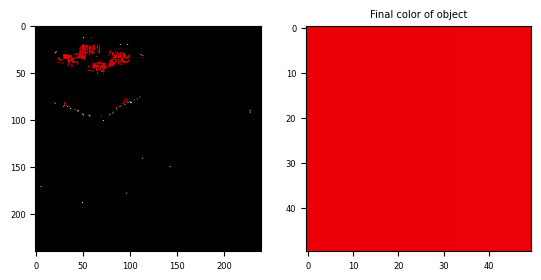

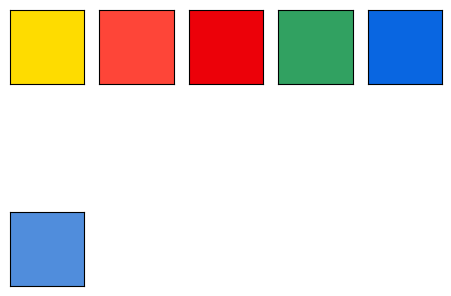

In [15]:
# example 
volume_properties= []
rgb_img = imageio.imread("photos/lego_sample.png")
plt.imshow(rgb_img)

material_colors_img, material_shading_img =hsv_analysis(rgb_img, 1)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties, len(volume_properties)) 



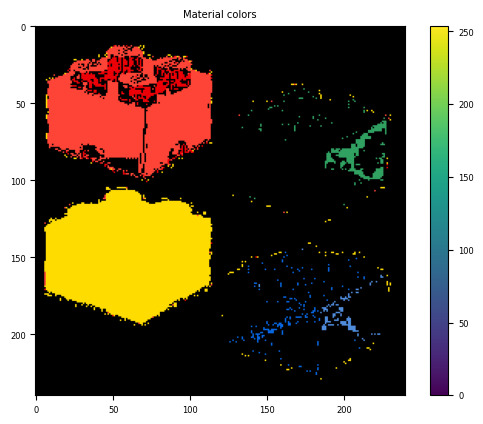

In [16]:
#convert from hsv to rgb
material_colors_img = cv.convertScaleAbs(material_colors_img)
material_colors_img = cv.cvtColor(material_colors_img, cv.COLOR_HSV2RGB)
material_shading_img = cv.convertScaleAbs(material_shading_img)
material_shading_img = cv.cvtColor(material_shading_img, cv.COLOR_HSV2RGB)


#show the material colors
plt.figure()
plt.imshow(material_colors_img)
plt.title('Material colors')
plt.colorbar()
plt.show()



There are  4 Hue peaks
there are  4  materials
volume properties [[125881, 0, 46, 98, 63, 255, 1], [22422, 0, 95, 91, 88, 255, 1], [4357, 0, 146, 145, 140, 255, 1], [4038, 0, 146, 147, 142, 255, 1]]


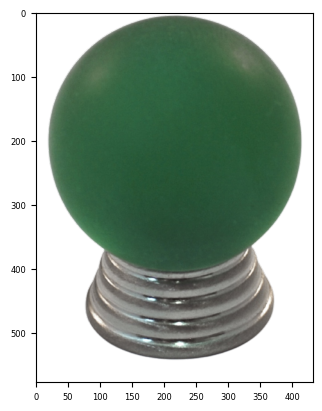

<Figure size 640x480 with 0 Axes>

In [17]:
volume_properties= []
rgb_img = imageio.imread("photos/materials_sample-removebg-preview.png")
plt.imshow(rgb_img)

material_colors_img, material_shading_img =hsv_analysis(rgb_img, 0)

volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties)



In [19]:
def show_material_img(material_colors_img, material_shading_img):
    #convert from hsv to rgb
    material_colors_img_rgb = cv.convertScaleAbs(material_colors_img)
    material_colors_img_rgb = cv.cvtColor(material_colors_img_rgb, cv.COLOR_HSV2RGB)
    material_shading_img_rgb = cv.convertScaleAbs(material_shading_img)
    material_shading_img_rgb = cv.cvtColor(material_shading_img_rgb, cv.COLOR_HSV2RGB)


#show the material colors
    plt.figure()
    plt.imshow(material_colors_img_rgb)
    plt.title('Material colors')
    plt.show()

#show the material shading
    plt.figure()
    plt.imshow(material_shading_img_rgb)
    plt.title('Material shading')
    plt.show()


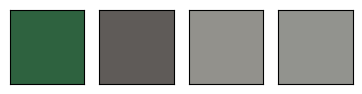

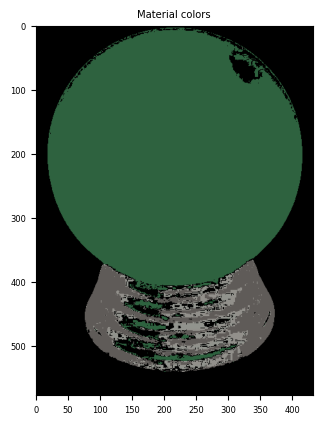

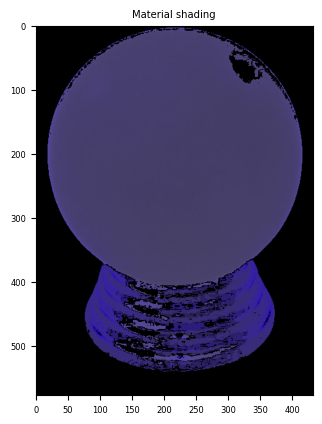

True

In [20]:
    
#show colors in order of importance
show_vp(volume_properties, len(volume_properties))
show_material_img(material_colors_img, material_shading_img)

#save the material colors

material_colors_img_rgb = cv.convertScaleAbs(material_colors_img)
material_colors_img_rgb = cv.cvtColor(material_colors_img_rgb, cv.COLOR_HSV2RGB)
cv.imwrite('material_colors.png', material_colors_img_rgb)


There are  4 Hue peaks
there is only one distinct peak in saturation
invalid material Value
there are no distinct peaks in saturation, here is the saturation histogram
there are distinct peaks in saturation and value, here are the saturation and value histograms


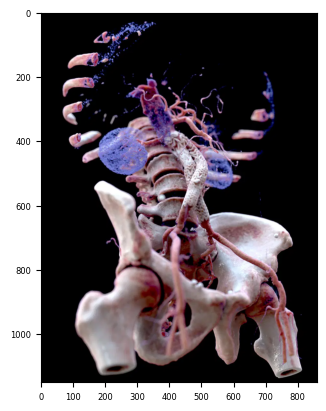

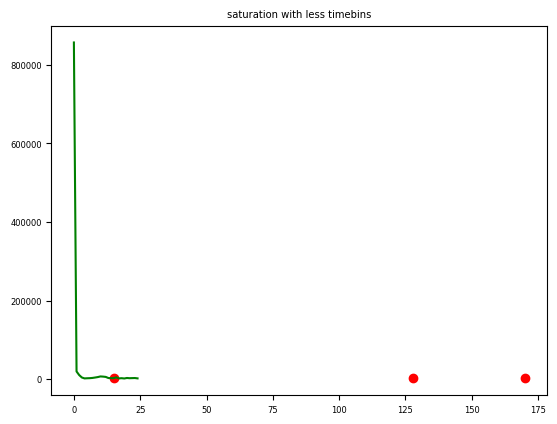

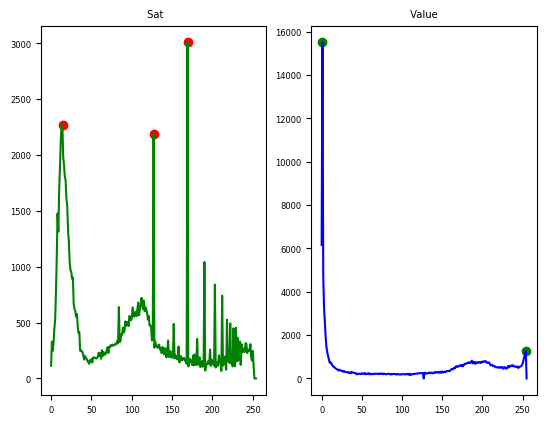

final color of object
number of pixels of object above 139360 , HSV 120 170 254
there is only one distinct peak in saturation
there are distinct peaks in saturation and value, here are the saturation and value histograms


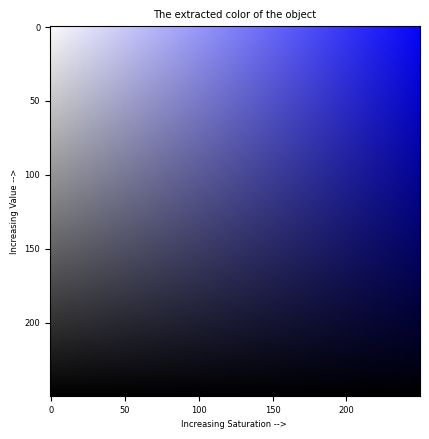

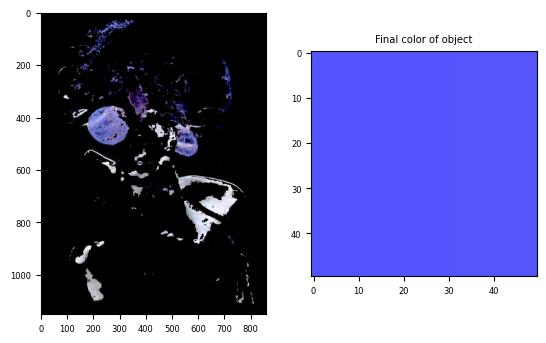

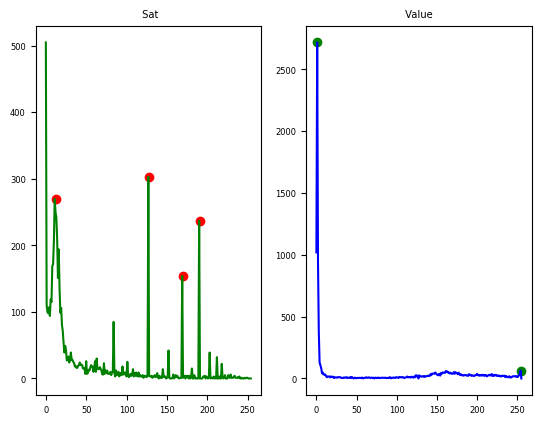

final color of object
number of pixels of object above 10652 , HSV 150 129 254
invalid material Saturation
there are  2  materials
volume properties [[139360, 0, 85, 85, 254, 255, 1], [10652, 0, 254, 126, 254, 255, 1]]


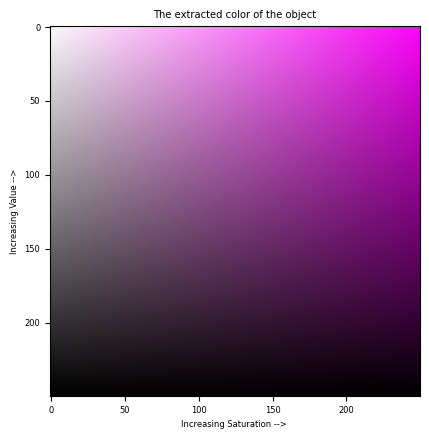

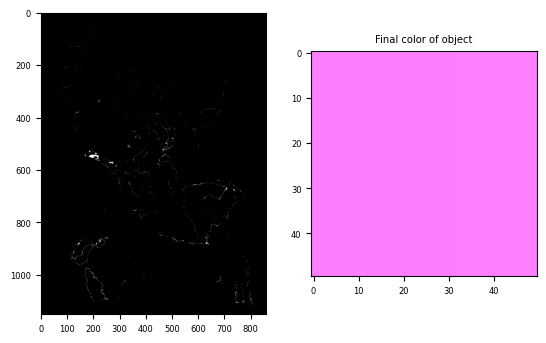

<Figure size 640x480 with 0 Axes>

In [25]:

volume_properties= []
rgb_img = imageio.imread("photos/pretty_image.png")
plt.imshow(rgb_img)
#blurring
kernel_size=3
smooth_img = cv.GaussianBlur(rgb_img, (kernel_size, kernel_size), 0)

material_colors_img, material_shading_img =hsv_analysis(smooth_img, 1)

volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties)

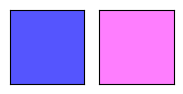

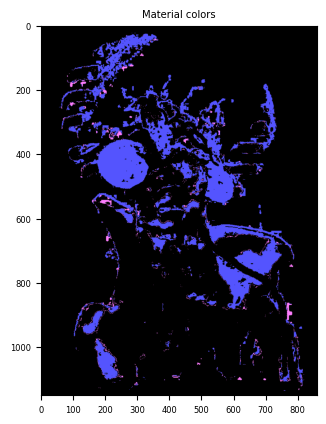

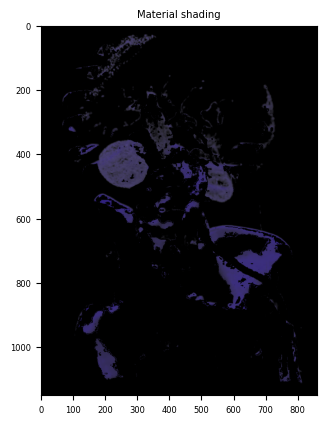

In [22]:
show_vp(volume_properties, len(volume_properties) )
show_material_img(material_colors_img, material_shading_img)

There are  4 Hue peaks
there are no distinct peaks in saturation


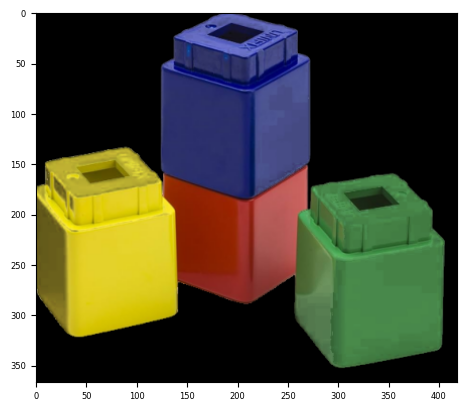

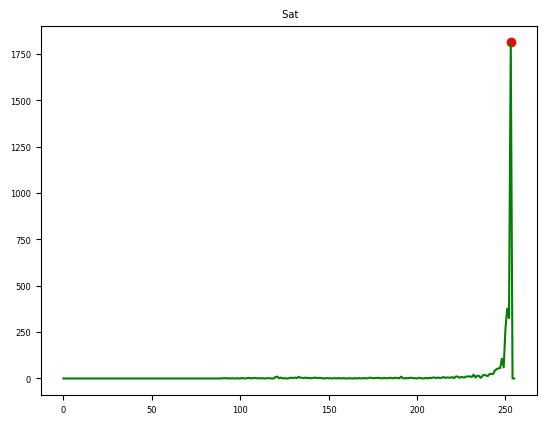

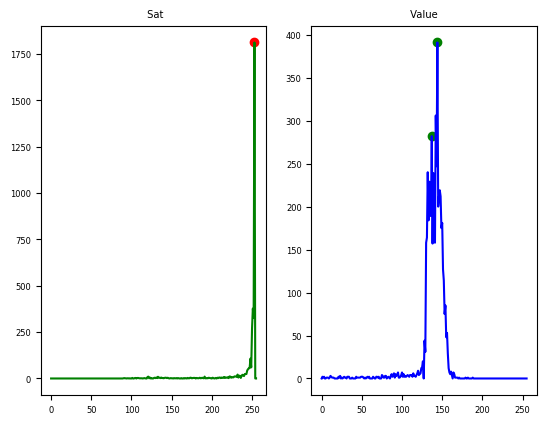

number of pixels 5522 , HSV 7 253 144
there are no distinct peaks in saturation


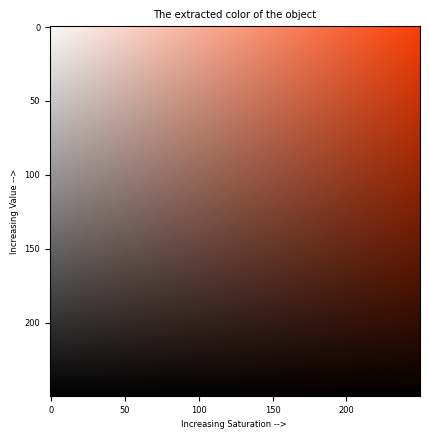

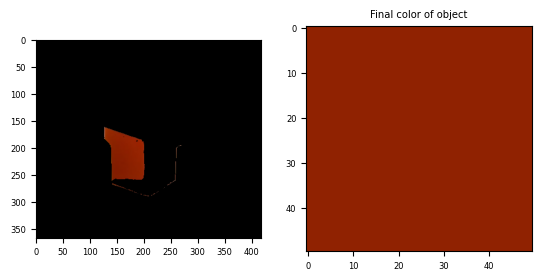

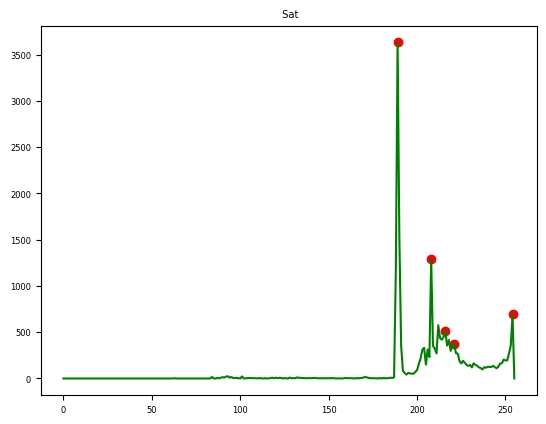

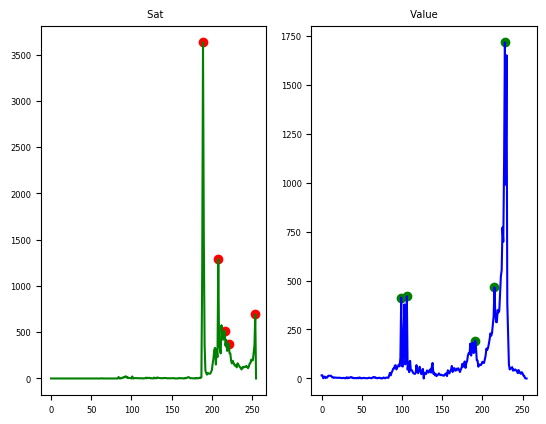

number of pixels 22752 , HSV 27 254 228
there is only one distinct peak in saturation


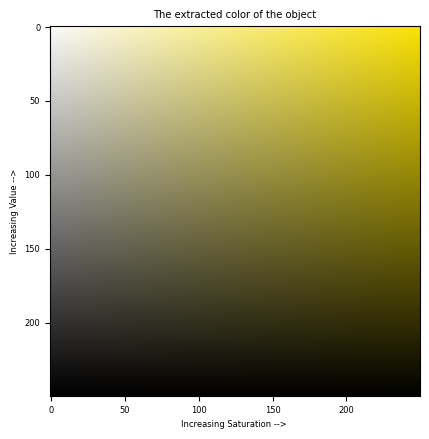

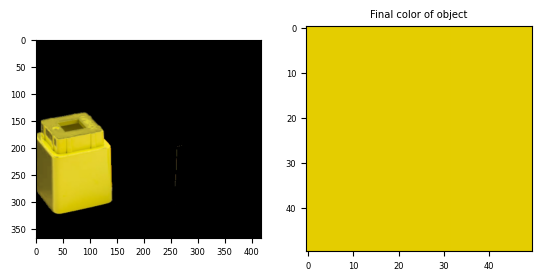

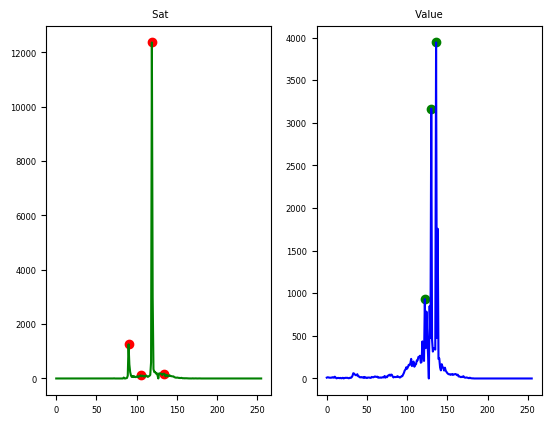

number of pixels 24266 , HSV 61 128 136
there are several distinct peaks in saturation
there are  4  materials
volume properties [[24266, 0, 68, 136, 70, 255, 1], [22752, 0, 228, 205, 1, 255, 1], [7083, 0, 77, 82, 145, 255, 1], [5522, 0, 144, 34, 1, 255, 1]]


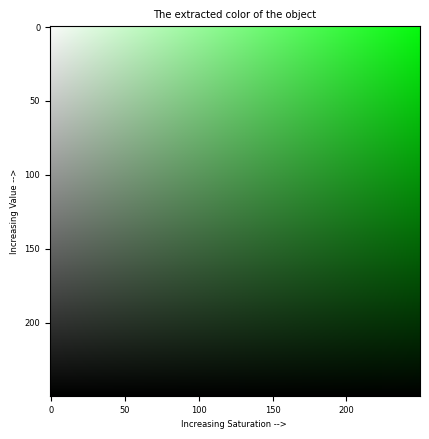

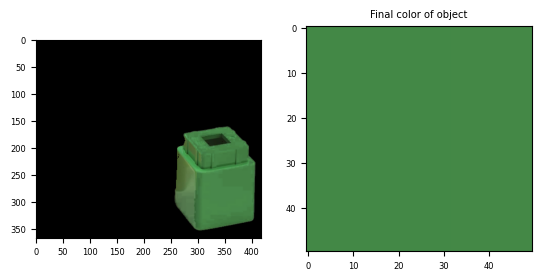

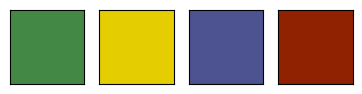

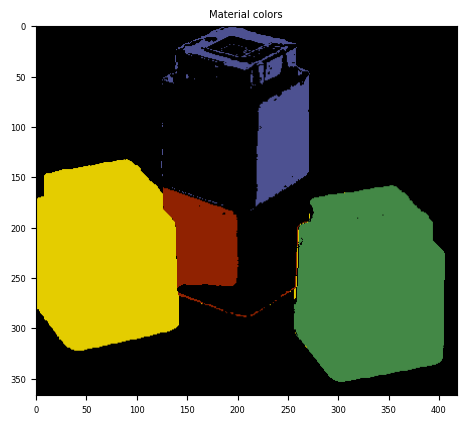

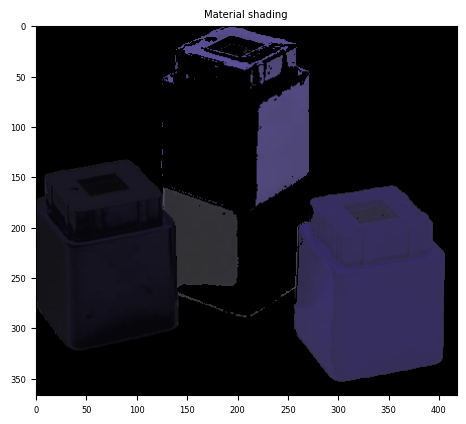

In [104]:
volume_properties= []
rgb_img = imageio.imread("photos/diffuse05.png")
plt.imshow(rgb_img)

material_colors_img, material_shading_img =hsv_analysis(rgb_img, 1)

volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance


show_vp(volume_properties,len(volume_properties))
show_material_img(material_colors_img, material_shading_img)

[[[250 253 254]]]


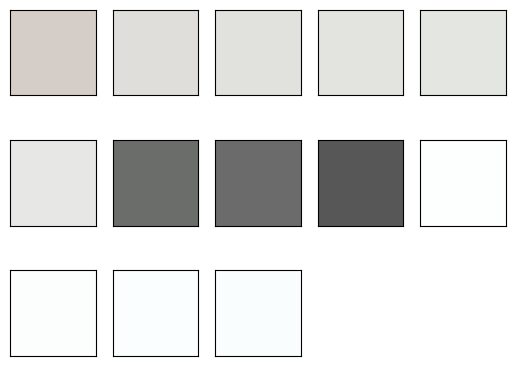

In [118]:

hsv= [  13, 17, 213, 24 ,5, 223, 30 ,4, 225 ,36 ,5 ,228, 42, 5 ,230, 50 ,2 ,232, 55 ,6 ,109, 60, 2, 107, 70 ,3 ,87, 75 ,1, 254
,83 ,3, 254
,90 ,4 ,254
 ,96 ,4 ,254]

plt.figure()
for i in range(0, len(hsv)//3):
    plt.subplot((len(hsv)//3)//5 +1, 5, i+1)
    material_color_hsv= np.uint8([[[hsv[3*i],hsv[3*i+ 1],hsv[3*i+2]]]])  
    material_color_rgb = cv.cvtColor(material_color_hsv, cv.COLOR_HSV2RGB)
    color_image = print_color(material_color_rgb[0][0][0],material_color_rgb[0][0][1],material_color_rgb[0][0][2])
    plt.imshow(color_image)
    plt.xticks([])
    plt.yticks([])
    


def show_vp(volume_properties, top=len(volume_properties), show=0):
    plt.figure()
    for i in range(0,top):
        #divide by 5 and round up
        plt.subplot(len(volume_properties)//5 +1, 5, i+1)
        color_image = print_color(volume_properties[i][2],volume_properties[i][3],volume_properties[i][4])
        plt.imshow(color_image)
        if show:
            plt.title(str(volume_properties[i][0])+ ',\n rgb: '+ str(volume_properties[i][2])+','+str(volume_properties[i][3])+','+str(volume_properties[i][4]))
        #dont show axis
        plt.xticks([])
        plt.yticks([])
        #make titles small
        plt.rcParams.update({'font.size': 6})
        #title to the right of image
        plt.subplots_adjust(right=0.8)


print(    material_color_rgb )